In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Running from the root makes things easy

In [2]:
%cd ../..

/home/kamen/Workspace/Coursework/year4/mlp/mlp-03


In [3]:
from src.datautils.sandia import SandiaDataProvider

# Setup data provider

In [4]:
train_batch_size = 16
test_batch_size = 10

train_data = SandiaDataProvider(which_set='train',
                                  dataset_home='datasets/sandia/',
                                  img_size=28)
val_data = SandiaDataProvider(which_set='valid',
                                  dataset_home='datasets/sandia/',
                                  img_size=28,
                                  normalize_mean=train_data.normalize_mean,
                                  normalize_sd=train_data.normalize_sd)
test_data = SandiaDataProvider(which_set='test',
                                  dataset_home='datasets/sandia/',
                                  img_size=28,
                                  normalize_mean=train_data.normalize_mean,
                                  normalize_sd=train_data.normalize_sd)

# Define models

In [5]:
import src
import importlib
importlib.reload(src.autoencoders)

AttributeError: module 'src' has no attribute 'autoencoders'

In [6]:
from src.autoencoders import Conv2DAutoencoder, PCAAutoencoder, FeedforwardAutoencoder
from src.reasoning_agents import FFNReasoningAgent
from src.classifiers import PairwiseClassifier
from src.utiq import UTIQ

lr = 0.1
momentum = 0.5
use_cuda = torch.cuda.is_available()
latent_size = 160

# autoencoder = PCAAutoencoder(latent_size)
# autoencoder = Conv2DAutoencoder(latent_size)
autoencoder = FeedforwardAutoencoder(latent_size)

hidden_dim = 200
learning_rate = 0.05
num_hidden_layers = 3

reasoning_agent = FFNReasoningAgent(latent_size, hidden_dim, num_hidden=num_hidden_layers)
# reasoning_agent = FFNReasoningAgent(latent_size)


classifier = PairwiseClassifier(latent_size)

model = UTIQ(autoencoder, reasoning_agent, classifier, use_classifier=False)
if use_cuda:
    model.cuda()

# Train only autoencoder

# If PCA

In [8]:
# train_data.inputs is still num_ex x im_width x im_height x num_im
X = train_data.inputs.transpose(3, 0, 1, 2).reshape(-1, 28 * 28)
model.autoencoder.train(X)

# If differentiable

In [7]:
optimizer = optim.SGD(model.autoencoder.parameters(), lr=lr, momentum=momentum)

In [8]:
log_interval = 50
losses = []
def train_autoencoder_only(epoch):
    model.autoencoder.train()
    # Get new gen object at every epoch
    train_loader = train_data.get_image_batch_iterator(train_batch_size)
    for batch_idx, (data, _) in enumerate(train_loader):
        # Set autoencoder target
        target = data
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        # Ignore latent representations
        output, _ = model.autoencoder(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])
        if batch_idx % log_interval == 0:
            print('Train Epoch: {0} Loss: {1:.6f}'.format(epoch, loss.data[0]))

epochs = 10
for epoch in range(1, epochs + 1):
    train_autoencoder_only(epoch)

Train Epoch: 1 Loss: 0.689207
Train Epoch: 1 Loss: 0.709388
Train Epoch: 1 Loss: 1.142289
Train Epoch: 1 Loss: 1.072686
Train Epoch: 1 Loss: 1.047271
Train Epoch: 1 Loss: 0.529345
Train Epoch: 1 Loss: 0.548501
Train Epoch: 1 Loss: 0.867828
Train Epoch: 1 Loss: 0.666992
Train Epoch: 1 Loss: 0.773277
Train Epoch: 1 Loss: 0.668985
Train Epoch: 1 Loss: 0.627351
Train Epoch: 1 Loss: 0.763695
Train Epoch: 1 Loss: 0.712615
Train Epoch: 2 Loss: 0.524853
Train Epoch: 2 Loss: 0.534613
Train Epoch: 2 Loss: 0.718771
Train Epoch: 2 Loss: 0.632749
Train Epoch: 2 Loss: 0.302936
Train Epoch: 2 Loss: 0.543076
Train Epoch: 2 Loss: 0.427922
Train Epoch: 2 Loss: 0.645674
Train Epoch: 2 Loss: 0.544084
Train Epoch: 2 Loss: 0.520974
Train Epoch: 2 Loss: 0.400689
Train Epoch: 2 Loss: 0.417545
Train Epoch: 2 Loss: 0.630865
Train Epoch: 2 Loss: 0.590518
Train Epoch: 3 Loss: 0.481473
Train Epoch: 3 Loss: 0.451102
Train Epoch: 3 Loss: 0.396917
Train Epoch: 3 Loss: 0.407912
Train Epoch: 3 Loss: 0.700011
Train Epoc

In [9]:
data, output = None, None
test_loader = test_data.get_image_batch_iterator(test_batch_size)
data, _ = next(test_loader)
# Set autoencoder target
target = data
if use_cuda:
    data, target = data.cuda(), target.cuda()
data, target = Variable(data), Variable(target)
# Ignore latent representations
output, _ = model.autoencoder(data)

In [10]:
data_np = data.squeeze().cpu().data.numpy()
output_np = output.squeeze().cpu().data.numpy()

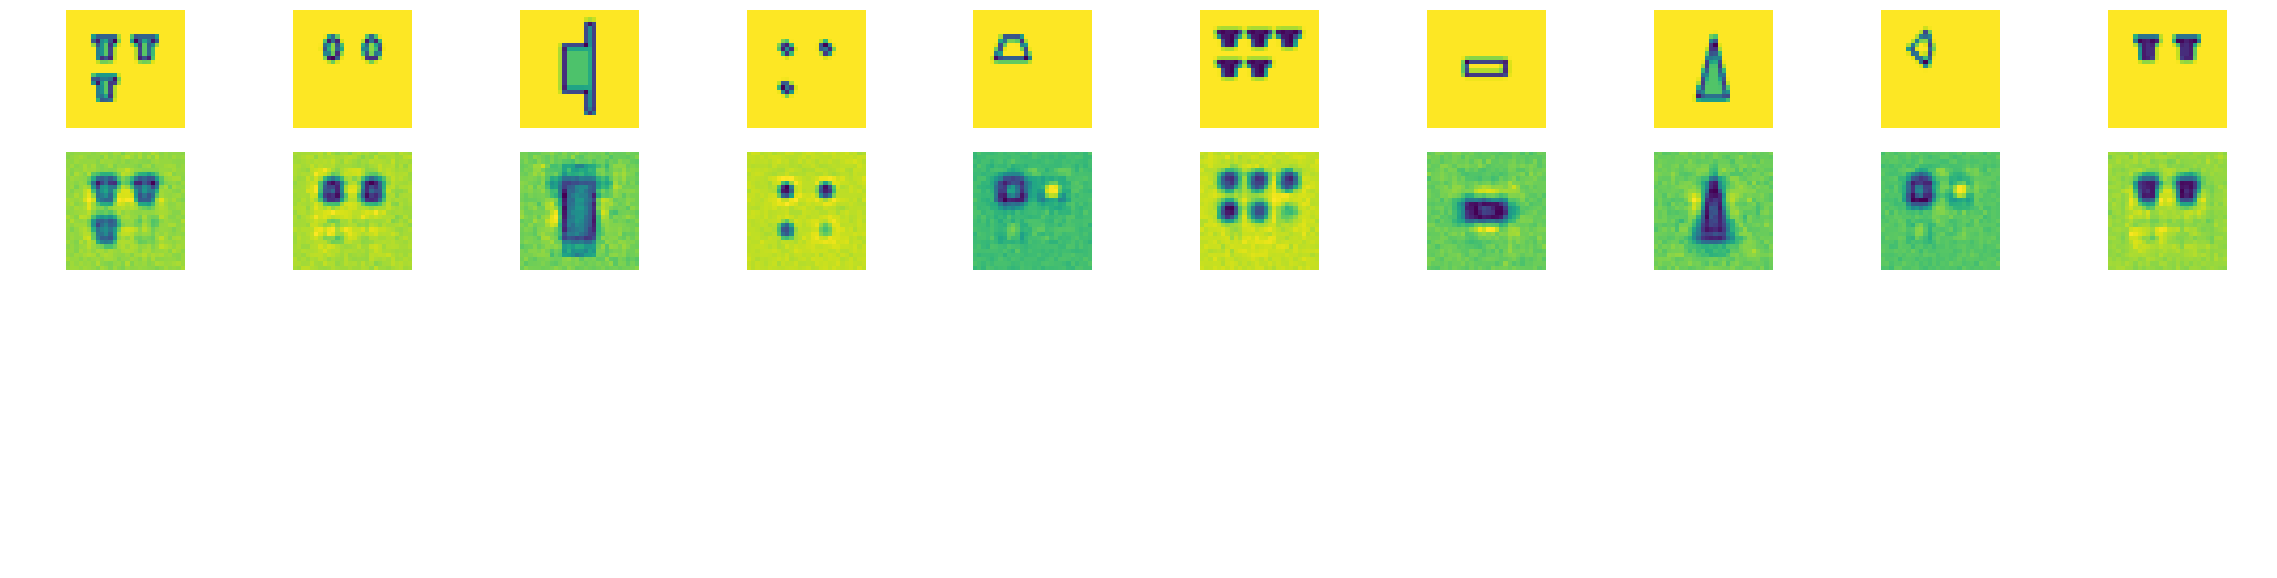

In [11]:
from src.utils import show_grid_of_images
show_grid_of_images(np.concatenate([data_np, output_np]), img_size=(test_batch_size, 1), grid_size=(4, test_batch_size))

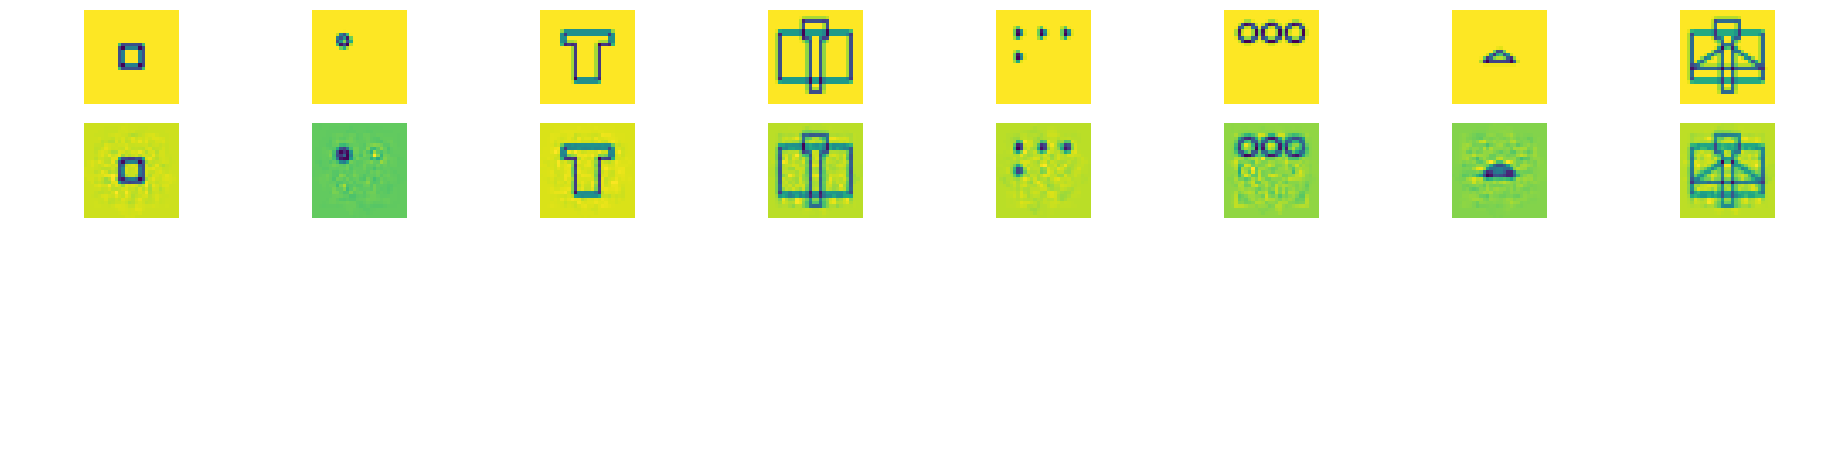

In [61]:
show_grid_of_images(np.concatenate([data_np, output_np]), img_size=(test_batch_size, 1), grid_size=(4, test_batch_size))

In [16]:
autoencoder.set_frozen(True)

### Train rest of architecture

In [6]:
optimizer = optim.SGD([x for x in model.parameters() if x.requires_grad], lr=lr, momentum=momentum)

In [12]:
torch.manual_seed(123)

In [13]:
optimizer = optim.SGD([x for x in model.parameters() if x.requires_grad], lr=learning_rate)

In [14]:
import src
import importlib
importlib.reload(src.utils)
importlib.reload(src.train_test)

AttributeError: module 'src' has no attribute 'train_test'

In [15]:
from src.train_test import train, test

epochs = 40
train(model, optimizer, train_data, val_data, use_cuda, train_batch_size, epochs)
test(model, optimizer, test_data, use_cuda, test_batch_size, ['3_layer'])

Train: Epoch: 1 Loss: 8.375509
Validation: Epoch: 1 Loss: 4.024519
Train: Epoch: 2 Loss: 3.611865
Validation: Epoch: 2 Loss: 1.631674
Train: Epoch: 3 Loss: 2.438487
Validation: Epoch: 3 Loss: 2.642994
Train: Epoch: 4 Loss: 2.325176
Validation: Epoch: 4 Loss: 2.180638
Train: Epoch: 5 Loss: 2.680940
Validation: Epoch: 5 Loss: 1.913320
Train: Epoch: 6 Loss: 1.936447
Validation: Epoch: 6 Loss: 1.973444
Train: Epoch: 7 Loss: 2.315110
Validation: Epoch: 7 Loss: 1.925960
Train: Epoch: 8 Loss: 2.244886
Validation: Epoch: 8 Loss: 2.115450
Train: Epoch: 9 Loss: 2.056547
Validation: Epoch: 9 Loss: 2.112490
Train: Epoch: 10 Loss: 1.470002
Validation: Epoch: 10 Loss: 2.249899
Train: Epoch: 11 Loss: 2.739722
Validation: Epoch: 11 Loss: 2.010556
Train: Epoch: 12 Loss: 1.087912
Validation: Epoch: 12 Loss: 2.204225
Train: Epoch: 13 Loss: 1.525921
Validation: Epoch: 13 Loss: 2.714277
Train: Epoch: 14 Loss: 1.098662
Validation: Epoch: 14 Loss: 1.339887
Train: Epoch: 15 Loss: 1.076264
Validation: Epoch: 1

In [16]:
from src.utils import make_vars

test_loader = test_data.get_batch_iterator(test_batch_size, transpose_inputs=True, separate_inputs=True)

(q_vectors, a_vectors), labels = next(test_loader)
q_vectors, a_vectors, labels = make_vars([q_vectors, a_vectors, labels], ['float', 'float', 'long'], use_cuda=use_cuda)
logits, latent_prediction, decoded_q_vectors, decoded_a_vectors, latent_a_vectors = model(q_vectors, a_vectors)

In [17]:
targets = a_vectors

indices = torch.from_numpy(np.arange(test_batch_size)).long()
if use_cuda:
    indices = indices.cuda()
targets = targets[indices, labels.data].squeeze()

In [31]:
# When PCA
decoded_prediction = model.autoencoder.decoder(latent_prediction.view(-1, latent_size)).squeeze().view(test_batch_size, 28, 28)

ValueError: Expected 4D tensor as input, got 2D tensor instead.

In [32]:
# When differentiable Conv AE
decoded_prediction = model.autoencoder.decoder(latent_prediction.view(-1, latent_size, 1, 1)).squeeze()

In [18]:
# When differentiable Linear AE
decoded_prediction = model.autoencoder.decoder(latent_prediction.view(-1, latent_size)).squeeze().view(test_batch_size, 28, 28)

### Show as part of matrix

In [32]:
import src
import importlib
importlib.reload(src.utils)

<module 'src.utils' from '/home/kamen/Workspace/Coursework/year4/mlp/mlp-03/src/utils.py'>

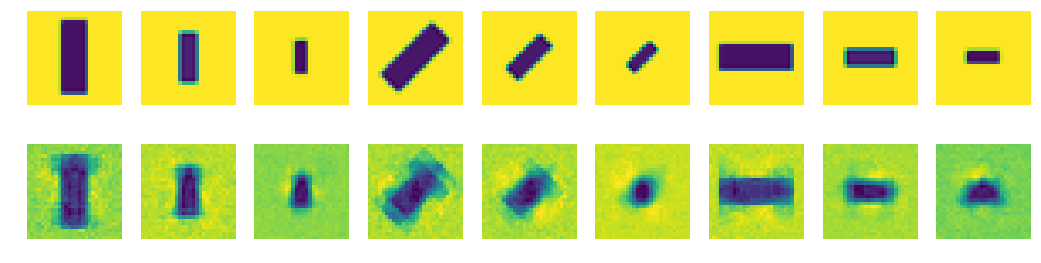

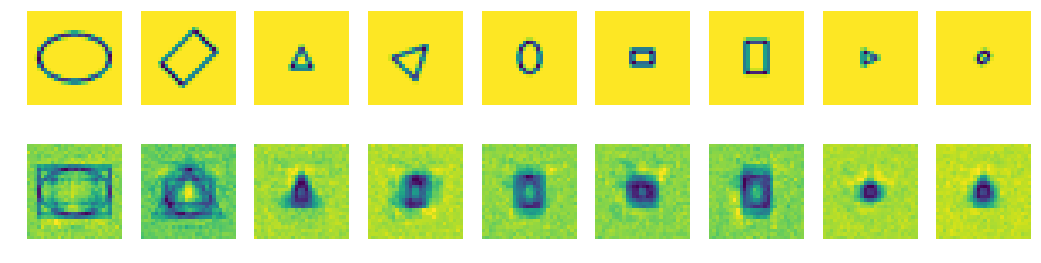

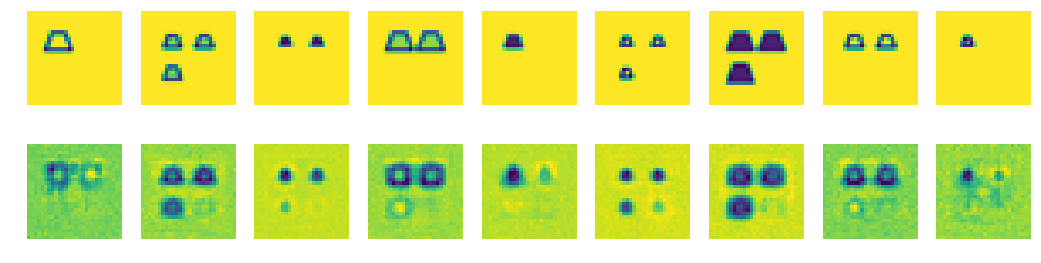

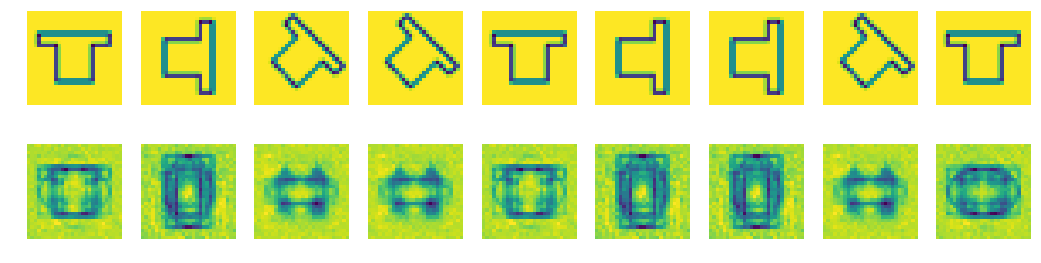

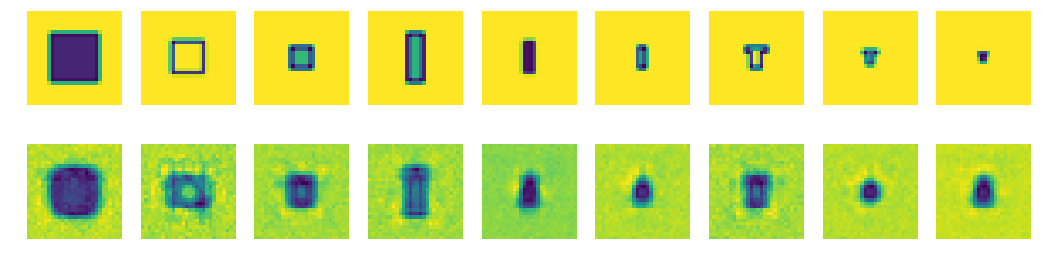

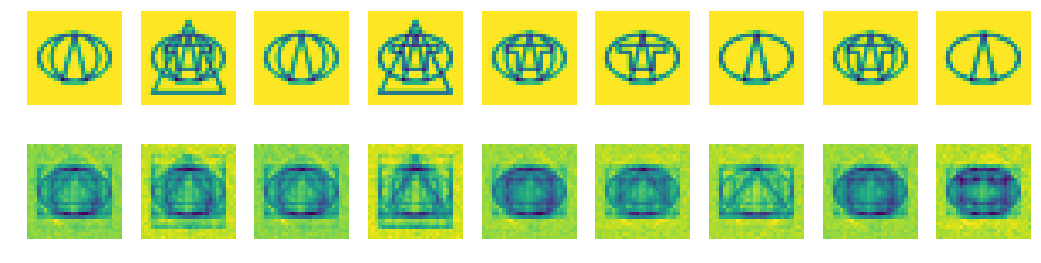

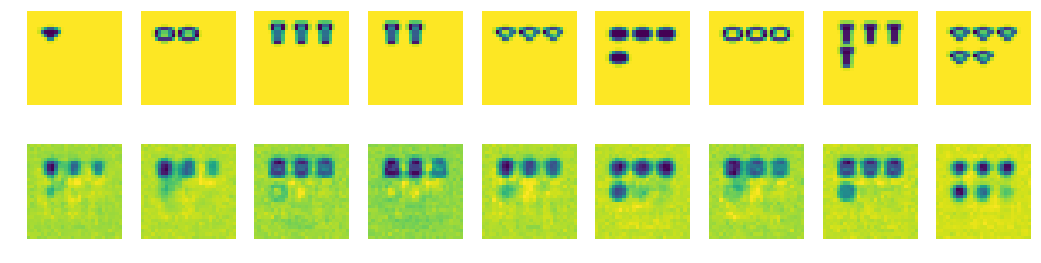

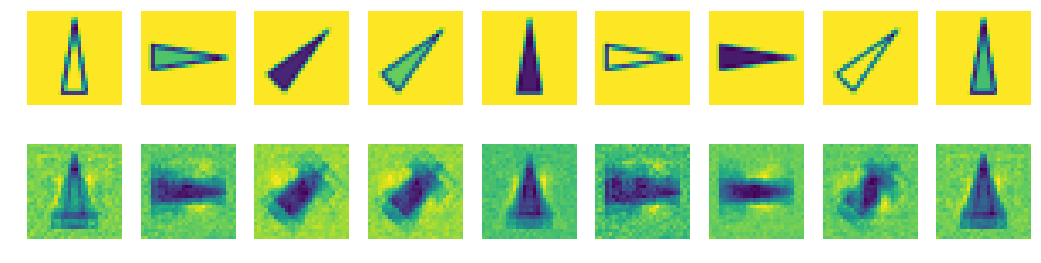

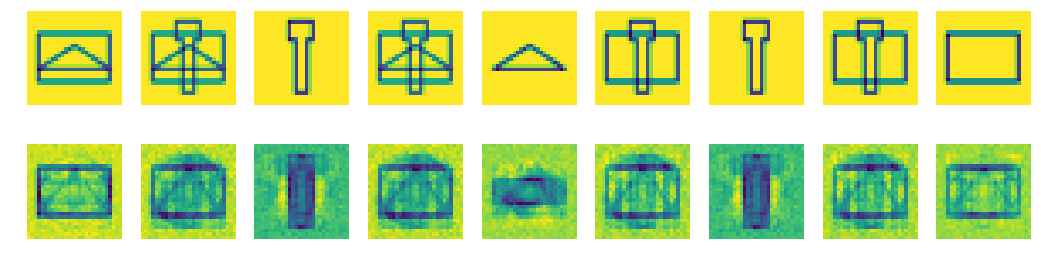

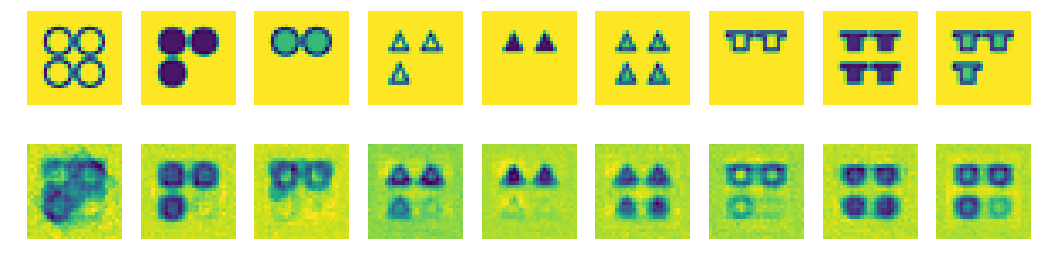

In [19]:
from src.utils import show_matrix
show_matrix(q_vectors, targets, decoded_q_vectors, decoded_prediction)

### Compare with available answers

In [26]:
a_vectors_np = a_vectors.cpu().data.numpy()
decoded_prediction_np = decoded_prediction.cpu().data.numpy()

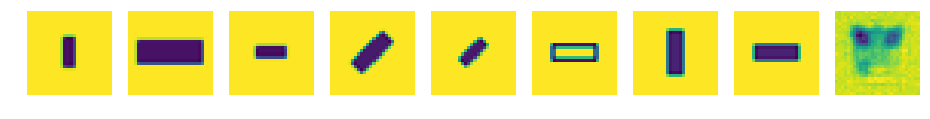

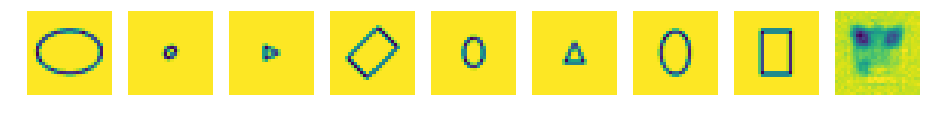

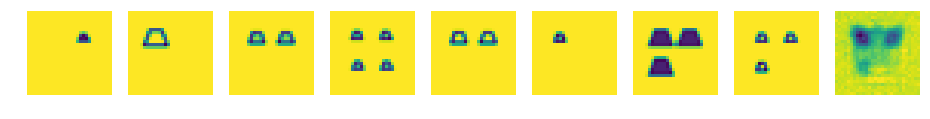

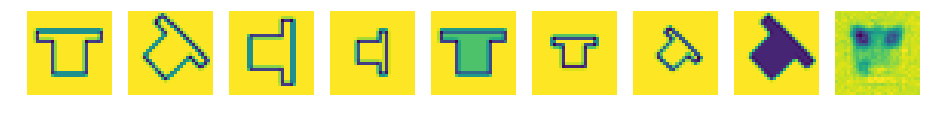

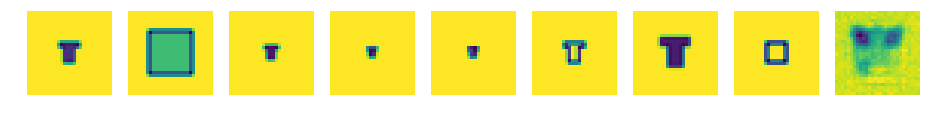

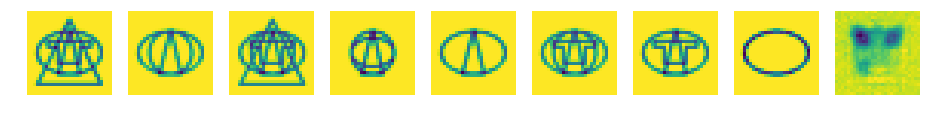

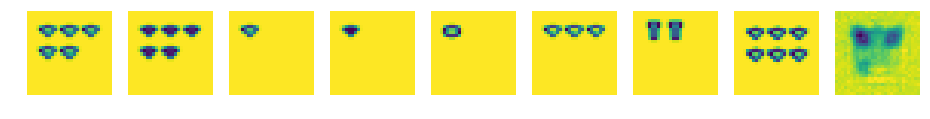

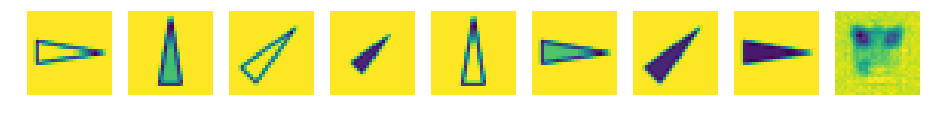

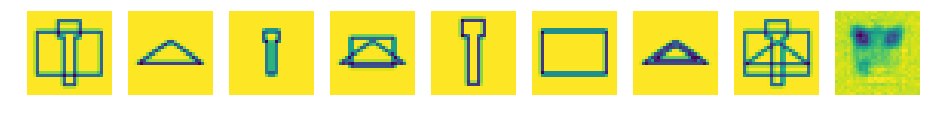

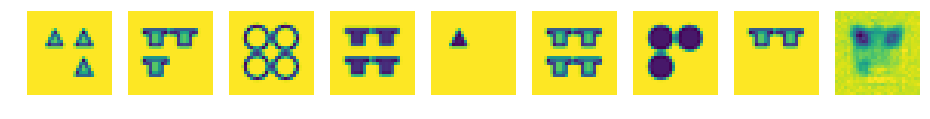

In [27]:
from src.utils import show_grid_of_images

for i in range(test_batch_size):
    show_grid_of_images(np.concatenate([a_vectors_np[i], decoded_prediction_np[i:i+1]]), img_size=(16, 1), grid_size=(1, 9))